# Speech-based Emotion Recognition for Voice Comms.
## Script for batch data processing/augmentation

In [42]:
import soundfile
import numpy as np
import math
import librosa
import glob
import os
import random
import matplotlib.pyplot as plt
from pysndfx import AudioEffectsChain
from pydub.silence import detect_nonsilent
from pydub import AudioSegment
from pytexit import py2tex

In [20]:
class AugmentData:
    def read_audio_file(self, file_path):
        data = librosa.core.load(file_path, sr=None)[0]
        return data
    
    # generating new .wav files from numpy array
    def write_audio_file(self, file, data, sample_rate=16000):
        librosa.output.write_wav(file, data, sample_rate)
    
    # example plots
    def plot_time_series(self, data):
        fig = plt.figure(figsize=(10, 4))
        plt.title('Raw wave')
        plt.ylabel('Amplitude')
        plt.style.use('ggplot')
        plt.plot(np.linspace(0, 1, len(data)), data)
        plt.show()
        
    # Silence removal, used for preprocessing each dataset
    def remove_sil(self, signal, basename):
        non_sil_times = detect_nonsilent(signal, min_silence_len=50, silence_thresh=signal.dBFS * 1.5)
        if len(non_sil_times) > 0:
            non_sil_times_concat = [non_sil_times[0]]
            if len(non_sil_times) > 1:
                for t in non_sil_times[1:]:
                    if t[0] - non_sil_times_concat[-1][-1] < 200:
                        non_sil_times_concat[-1][-1] = t[1]
                    else:
                        non_sil_times_concat.append(t)
            non_sil_times = [t for t in non_sil_times_concat if t[1] - t[0] > 350]
            signal[non_sil_times[0][0]: non_sil_times[-1][1]].export(os.path.join('data/TESS-nosil', basename), format="wav")
    
    # SNR augment(white noise generation) in dB
    # given a signal and desired SNR, 
    # this gives the required AWGN that should be added to the signal to achieve desired SNR
    def add_noise(self, signal, snr):
        #RMS value of signal
        RMS_s = math.sqrt(np.mean(signal**2))
        #RMS values of noise
        RMS_n = math.sqrt(RMS_s**2/(pow(10,snr/20)))
        #Additive white gausian noise. Therefore mean=0
        #Because sample length is large (typically > 40000)
        #we can use the population formula for standard daviation.
        #because mean=0 STD=RMS
        STD_n = RMS_n
        noise = np.random.normal(0, STD_n, signal.shape[0])
        return noise
    
    # background noise (overlaying other voices, mechanical noise, etc.)
    # given a signal, noise (audio) and desired SNR, 
    # this gives the noise (scaled version of noise input) that gives the desired SNR
    def add_bg_noise(self,signal, noise, snr):
        RMS_s = math.sqrt(np.mean(signal**2))
        #required RMS of noise
        RMS_n = math.sqrt(RMS_s**2/(pow(10,snr/20)))

        #current RMS of noise
        RMS_n_current = math.sqrt(np.mean(noise**2))
        noise = noise * (RMS_n/RMS_n_current)
        return noise

    # reverb (decay time/wet level)
    def add_reverb(self,signal):
        # hardcoded args for batch processing
        fx = (
            AudioEffectsChain()
            .reverb(reverberance=20,
               hf_damping=75,
               room_scale=2,
               stereo_depth=20,
               pre_delay=0,
               wet_gain=0,
               wet_only=True)
        )
        
        y = fx(signal)
        return y
    
    # distortion/overdrive (clipping/nonlinear effects/mic emulation)
    def add_overdrive(self, signal):
        fx = (
            AudioEffectsChain()
            .overdrive(gain=30, colour=100)
        )
        
        y = fx(signal)
        return y

In [4]:
# Create a new instance of AugmentData class
ad = AugmentData()

# Silence removed paths
ravdess_path = "data/RAVDESS-nosil/*.wav"
bg_noise_src = "data/augment-bg/src/office/"
c_path = "data/CREMA-D/*.wav"

In [28]:
# # Remove Silence
# # PATH SHOULD BE ORIGINAL FOLDER
# for file in glob.glob("data/TESS/*/*.wav"):
#     # get the base name of the audio file
#     basename = os.path.basename(file)
    
#     data = AudioSegment.from_file(file, format="raw", sample_width=4, channels=1,frame_rate=16000)
#     ad.remove_sil(data, basename)

In [5]:
# White Noise
for file in glob.glob(c_path):
    # get the base name of the audio file
    basename = os.path.basename(file)
    data = ad.read_audio_file(file)
    
    # Adding wn to soundfile
    data_noise = ad.add_noise(data, 20)
    datawn = data + data_noise
    
    # Write augmented soundfile wn
    ad.write_audio_file(os.path.join('data/augment-wn/CREMA-D', basename), datawn)

In [6]:
# BG Noise
def getRandomFile(dir_path):
    files = os.listdir(dir_path)
    counter= random.randrange(0, len(files))
    return dir_path+files[counter]

for file in glob.glob(c_path):
    # get the base name of the audio file
    basename = os.path.basename(file)
    data = ad.read_audio_file(file)

    # Adding custom bg noise to soundfile
    bgsource = ad.read_audio_file(getRandomFile(bg_noise_src))
    data_background = ad.add_bg_noise(data, bgsource, 20)
    databg = data + data_background[:len(data)]

    # Write augmented soundfile bg
    ad.write_audio_file(os.path.join('data/augment-bg/CREMA-D', basename), databg)

In [7]:
# Reverb
for file in glob.glob(c_path):
    # get the base name of the audio file
    basename = os.path.basename(file)
    data = ad.read_audio_file(file)

    # Adding reverb to soundfile
    data_reverb = ad.add_reverb(data)
    datarev = data + data_reverb

    # Write augmented soundfile reverb
    ad.write_audio_file(os.path.join('data/augment-reverb/CREMA-D', basename), datarev)

In [8]:
# Overdrive
for file in glob.glob(c_path):
    # get the base name of the audio file
    basename = os.path.basename(file)
    data = ad.read_audio_file(file)

    # Simulated overdrive for soundfile
    data_od = ad.add_overdrive(data)

    # Write augmented soundfile reverb
    ad.write_audio_file(os.path.join('data/augment-overdrive/CREMA-D', basename), data_od)

In [ ]:
#todo:
## codec compression emulation (different bitrates, simulated cutouts)
    # simulate specs of compression algorithms

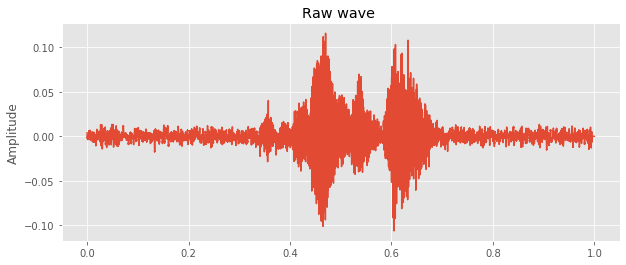

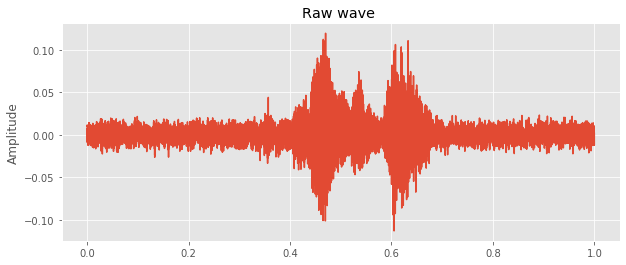

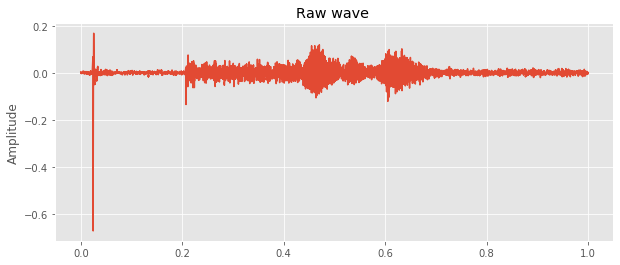

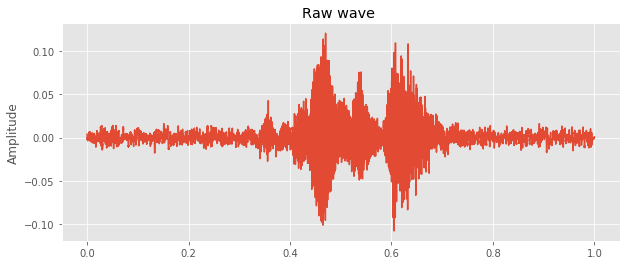

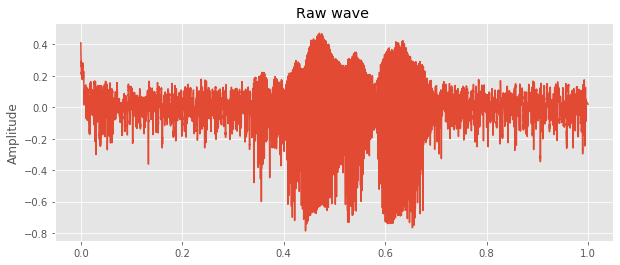

In [75]:
# plot last file in loop as example
ad.plot_time_series(data)
ad.plot_time_series(datawn)
ad.plot_time_series(databg)
ad.plot_time_series(datarev)
ad.plot_time_series(data_od)